c:\Users\lc100\AppData\Local\miniconda3\envs\frameSubtraction\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\lc100\AppData\Local\miniconda3\envs\frameSubtraction\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\lc100\AppData\Local\miniconda3\envs\frameSubtraction\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"



very blurry
(32, 32, 3)
(64, 64, 3)


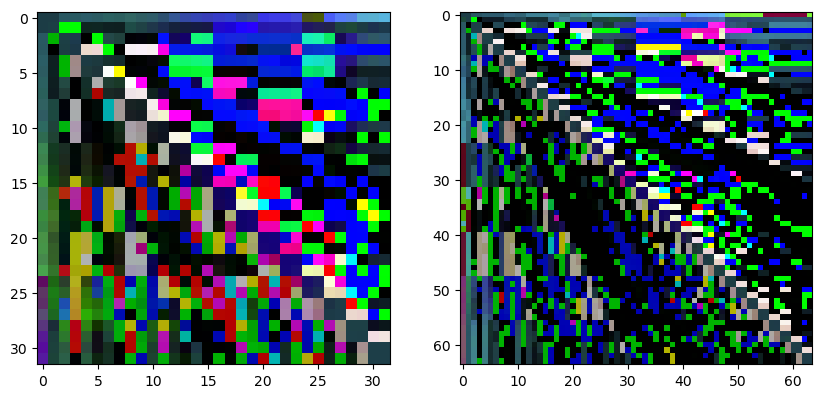

28
28
29
28
---------------------------------------------------------------------------------------------
[[[28 60 69]
  [29 60 69]]

 [[28 60 69]
  [28 63 69]]] 
------
 [[[30 62 71]
  [30 62 71]]

 [[30 74 59]
  [30 62 71]]]

------
 8.666666666666666
---------------------------------------------------------------------------------------------


In [1]:
import cv2
import numpy as np
import random as rng
from ipynb.fs.full.wavelet import Wavelet
from ipynb.fs.full.white_select import selectGreenHSV
from ipynb.fs.full.subtraction import display

In [2]:

def initBlobDetect():
    params = cv2.SimpleBlobDetector_Params()
    
    # Change thresholds
    params.minThreshold = 1
    params.maxThreshold = 500
    
    # Filter by Area.
    params.filterByArea = True
    params.minArea = 700 #700
    params.maxArea = 3000 #3000
    
    # Filter by Circularity
    params.filterByCircularity = True
    params.minCircularity = 0.5
    
    # Filter by Convexity
    params.filterByConvexity = False
    #params.minConvexity = 0.99
    
    # Filter by Inertia
    params.filterByInertia = True
    params.minInertiaRatio = 0.05
    params.maxInertiaRatio = 0.9
    
    params.filterByColor = True
    params.blobColor = 255
    
    params.minDistBetweenBlobs = 30 #30 #10
    
    # Create a detector with the parameters
    ver = (cv2.__version__).split('.')
    if int(ver[0]) < 3 :
        detector = cv2.SimpleBlobDetector(params)
    else : 
        detector = cv2.SimpleBlobDetector_create(params)
        
    return detector

def checkBlob(detector,mask,frame,idx,show=False):# Setup SimpleBlobDetector parameters.
        
    # Detect blobs.
    keypoints = detector.detect(mask)
    
    # Draw detected blobs as red circles.
    # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    N=len(keypoints) 
    pts=[[0,0,0,0]]
    if N > 0:
        for i in range(N):
            
            x=int(keypoints[i].pt[0])
            y=int(keypoints[i].pt[1])
            d=int(keypoints[i].size)
            r=d//2
            
            if y-r>0 and x-r>0 and y+r<frame.shape[0] and x+r<frame.shape[1]: 
                box_cp=frame[y-r:y+r,x-r:x+r,:]
                sumGreen=selectGreenHSV(box_cp)
                
                display(box_cp,name="box blob")
                
                cv2.circle(frame,(x,y),1,(0,0,255),d)
                
                if sumGreen>1500:
                    print("blob green:",sumGreen)
                    b=[x,y,idx,0.25]
                    pts=np.append(pts,[b],axis=0) 
                    cv2.rectangle(frame,(x-r+5,y-r+5),(x+r-5,y+r-5),(255,0,0),-1)
                
                
    #frame_with_keypoints = cv2.drawKeypoints(frame, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    if show:
        display(frame,name='detect blob')
        
    if len(pts)>1:
        pts=pts[1:]
        return pts
    else:
        return None
 
    
######################################################################################################

def checkBoxes(frame_diff, boundingBoxes ,show=False,coeff=150,wave_temp=None,wave_temp2=None):
    """ select the ball among all the objects by using the wavelet transform

    Args:
        frame_diff (array): _description_
        boundingBoxes (list): boxes of all the objects
        show (bool, optional): to see the boxe selected if any. Defaults to False.
        coeff (int, optional): coeff of similitude maximum allowed. Defaults to 150.
        wave_temp (array, optional): wavelet transform of the template. Defaults to None.
        wave_temp2 (array, optional): wavelet transform of the black template. Defaults to None.

    Returns:
        array: best box
    """
    
    if wave_temp is None:
        print("error no template checkBoxes ")
        return None
    if wave_temp2 is None:
        wave_temp2=wave_temp
    
    # we don't consider boxes that are too small or too big
    size_min=32
    size_max=wave_temp.shape[0]*3
    
    maxBox=None 
    maxGreen=-1
    maxDiff=-1
    #totH=0    

    L=len(boundingBoxes)
    
    for box in boundingBoxes:

        if box[3]>size_min and box[3]<size_max and box[2]>size_min and box[2]<size_max and box[2]/box[3]<100 and box[2]/box[3]>0.001:

            box_cp = frame_diff[box[1]:(box[1]+box[3]),box[0]:(box[0]+box[2]),:]
                       
            #temp_hist0 = cv2.calcHist(box_cp, [0], None,[256],[0,256] )
            #temp_hist1 = cv2.calcHist(box_cp, [1], None,[256],[0,256] )
            #temp_hist2 = cv2.calcHist(box_cp, [2], None,[256],[0,256] )
            #tot_histogramm=np.sum(temp_hist0[120:130]+temp_hist1[120:130]+temp_hist2[120:130])
            
            wave_box=Wavelet(box_cp)

            diff1=cv2.absdiff(wave_temp[:2,:2,:2],wave_box[:2,:2,:2])#cv2.absdiff(wave_temp[0,0,:],wave_box[0,0,:])+cv2.absdiff(wave_temp[1,1,:],wave_box[1,1,:])
            diff2=cv2.absdiff(wave_temp2[:2,:2,:2],wave_box[:2,:2,:2])#cv2.absdiff(wave_temp2[0,0,:],wave_box[0,0,:])+cv2.absdiff(wave_temp2[1,1,:],wave_box[1,1,:])
            diff=min(np.sum(diff1),np.sum(diff2))
        
            diff=np.sum(diff)
            
            """
            sumGreen=selectGreenHSV(box_cp)
            
            if sumGreen<0.000000001:
                sumGreen=0.000000001
            """
            
            diff_weight=( diff/3 ) # +( 1000 / sumGreen)#+tot_histogramm
            
            if diff_weight is not None and coeff>diff_weight:
                coeff = diff_weight
                maxBox = box
                #maxGreen = sumGreen
                maxDiff = diff/3
                
            if L==1 and diff_weight<coeff+10:
                coeff=diff_weight
                maxBox=box

    if maxBox is None:
        return None
    
    #print("coeff box and green: ",maxDiff , maxGreen," => ",coeff )
    
    #if show:
    #    box_cp= frame_diff[maxBox[1]:(maxBox[1]+maxBox[3]),maxBox[0]:(maxBox[0]+maxBox[2]),:]   
    #    cv2.rectangle(frame_diff, (int(box[0]), int(box[1])),(int(box[0]+box[2]), int(box[1]+box[3])), (255,255,255), 2)        
    #    display(frame_diff,name='select box')
        
    return maxBox

